In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.stats.diagnostic
%matplotlib inline

In [11]:
df = pd.read_excel("BTC1.xlsx",parse_dates=['Date'], index_col='Date')
df.head()

,BTC,FGI,Fee,Float,VIX,Hash,SPX,Gold
Date,,,,,,,,
2019-01-02,8.279801,3.401197,-1.340825,16.447289,3.145014,17.557931,7.828050,7.160225
2019-01-03,8.252378,3.496508,-1.380702,16.447292,3.236716,17.583663,7.802982,7.160807
2019-01-04,8.257832,3.871201,-1.341915,16.446900,3.062456,17.543611,7.836741,7.162669
2019-01-07,8.300342,3.663562,-1.086708,16.446488,3.063391,17.489276,7.843727,7.163560
2019-01-08,8.301733,3.663562,-1.348216,16.446583,3.018960,17.669904,7.853376,7.157658


In [12]:
print(df.isnull().sum())

BTC      0
FGI      0
Fee      0
Float    0
VIX      0
Hash     0
SPX      0
Gold     0
dtype: int64


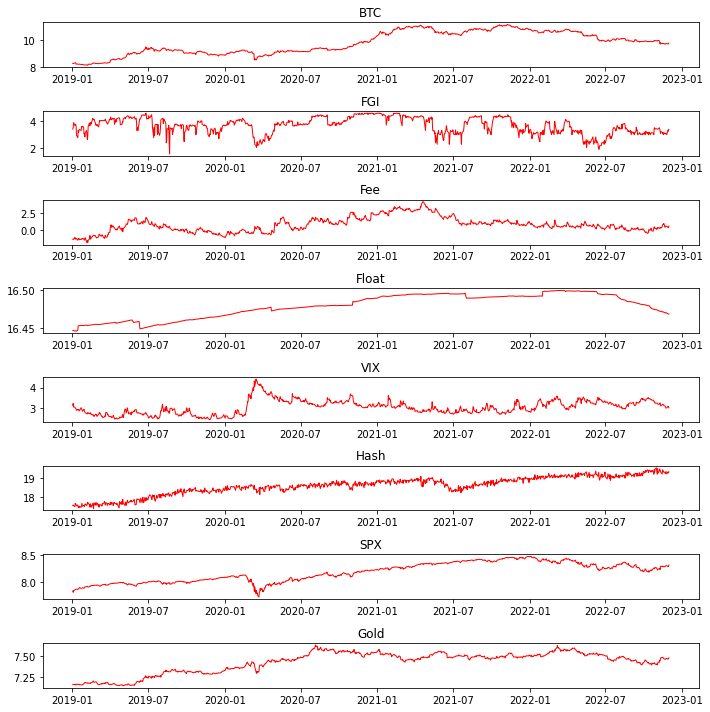

In [14]:
# 画出九个时间序列的图像
fig, axes = plt.subplots(nrows=8, ncols=1,figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
plt.tight_layout();

In [15]:
# step2：Granger’s Causality Test ， 检验不同序列之间存在互相影响
maxlag=12
test='ssr_chi2test'
variables=df.columns
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,BTC_x,FGI_x,Fee_x,Float_x,VIX_x,Hash_x,SPX_x,Gold_x
BTC_y,1.0000,0.0533,0.0494,0.2116,0.2032,0.2573,0.5667,0.0349
FGI_y,0.0000,1.0000,0.0043,0.4277,0.0000,0.0715,0.0000,0.2424
Fee_y,0.0073,0.0221,1.0000,0.1434,0.1505,0.0330,0.2534,0.2549
Float_y,0.2353,0.0052,0.0774,1.0000,0.4599,0.0077,0.2332,0.0808
VIX_y,0.0433,0.0342,0.0156,0.0623,1.0000,0.0201,0.0045,0.0119
Hash_y,0.0000,0.2352,0.0049,0.0000,0.0831,1.0000,0.0000,0.0000
SPX_y,0.0000,0.0057,0.0069,0.0855,0.0034,0.0275,1.0000,0.0877
Gold_y,0.0185,0.0738,0.0056,0.4067,0.0574,0.0632,0.2343,1.0000


In [16]:
# step3：ADF测试，检验单个变量是否平稳
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [17]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BTC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7904
 No. Lags Chosen       = 0
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.3852. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "FGI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1525
 No. Lags Chosen       = 5
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0008. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Fee" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Sign

In [18]:
# step4: 协整检验，检验多变量平稳性 
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
BTC    ::  201.72    > 143.6691  =>   True
FGI    ::  112.9     > 111.7797  =>   True
Fee    ::  77.24     > 83.9383   =>   False
Float  ::  45.0      > 60.0627   =>   False
VIX    ::  23.41     > 40.1749   =>   False
Hash   ::  12.5      > 24.2761   =>   False
SPX    ::  4.66      > 12.3212   =>   False
Gold   ::  0.8       > 4.1296    =>   False


In [19]:
# step5：划分训练集和测试集
nobs = 7  # 最后四个时间点作为测试集
df_train, df_test = df[0:-nobs], df[-nobs:]
df_train.head()

,BTC,FGI,Fee,Float,VIX,Hash,SPX,Gold
Date,,,,,,,,
2019-01-02,8.279801,3.401197,-1.340825,16.447289,3.145014,17.557931,7.828050,7.160225
2019-01-03,8.252378,3.496508,-1.380702,16.447292,3.236716,17.583663,7.802982,7.160807
2019-01-04,8.257832,3.871201,-1.341915,16.446900,3.062456,17.543611,7.836741,7.162669
2019-01-07,8.300342,3.663562,-1.086708,16.446488,3.063391,17.489276,7.843727,7.163560
2019-01-08,8.301733,3.663562,-1.348216,16.446583,3.018960,17.669904,7.853376,7.157658


In [20]:
# step6：使用VAR之前，先差分处理使单个变量变得平稳
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BTC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -32.4825
 No. Lags Chosen       = 0
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "FGI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.1806
 No. Lags Chosen       = 4
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Fee" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [21]:
cointegration_test(df_differenced)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
BTC    ::  1666.28   > 143.6691  =>   True
FGI    ::  1311.7    > 111.7797  =>   True
Fee    ::  1051.73   > 83.9383   =>   True
Float  ::  814.42    > 60.0627   =>   True
VIX    ::  608.06    > 40.1749   =>   True
Hash   ::  436.32    > 24.2761   =>   True
SPX    ::  266.76    > 12.3212   =>   True
Gold   ::  123.98    > 4.1296    =>   True


In [22]:
maxlag=12
test='ssr_chi2test'
variables=df.columns
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
grangers_causation_matrix(df_differenced, variables = df_differenced.columns)
# 平稳协整之后再进行格兰杰因果检验

,BTC_x,FGI_x,Fee_x,Float_x,VIX_x,Hash_x,SPX_x,Gold_x
BTC_y,1.0000,0.2444,0.1454,0.8188,0.1549,0.8216,0.4513,0.0227
FGI_y,0.0000,1.0000,0.0058,0.4718,0.0000,0.1572,0.0000,0.1640
Fee_y,0.0064,0.1675,1.0000,0.1266,0.1522,0.0193,0.1432,0.3494
Float_y,0.2457,0.0098,0.0894,1.0000,0.4163,0.0021,0.1214,0.3707
VIX_y,0.0320,0.0256,0.0080,0.2742,1.0000,0.0851,0.0021,0.4164
Hash_y,0.0511,0.1662,0.0012,0.6837,0.2516,1.0000,0.0244,0.0026
SPX_y,0.0001,0.0031,0.0182,0.2959,0.0019,0.0226,1.0000,0.0557
Gold_y,0.0086,0.0476,0.0031,0.5893,0.0419,0.0571,0.1506,1.0000


In [27]:
# step7：选择模型阶数并训练，根据AIC值，lag=2时达到局部最优
model = VAR(df_differenced)
AIC=[]
BIC=[]
FPE=[]
HQIC=[]
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    AIC.append(result.aic)
    BIC.append(result.bic)
    FPE.append(result.fpe)
    HQIC.append(result.hqic)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC : ', result.hqic, '\n')
df_r = pd.DataFrame({'Lag':range(1,10),'AIC':AIC,'BIC':BIC,'FPE':FPE,'HQIC':HQIC})
df_r.head(10)
# 看下面的表综合选出最合适的（越小越好）的滞后阶数

C:\Users\Cactus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,Lag,AIC,BIC,FPE,HQIC
0,1,-56.007653,-55.645627,4.744465e-25,-55.869854
1,2,-56.194451,-55.510063,3.936159e-25,-55.933938
2,3,-56.209046,-55.201766,3.879373e-25,-55.825606
3,4,-56.238193,-54.907492,3.768384e-25,-55.731611
4,5,-56.200053,-54.545397,3.915655e-25,-55.570113
5,6,-56.201866,-54.222722,3.909700e-25,-55.448354
6,7,-56.196937,-53.892770,3.930611e-25,-55.319636
7,8,-56.138586,-53.508858,4.169042e-25,-55.137278
8,9,-56.252247,-53.296421,3.723706e-25,-55.126716


In [28]:
# 选择lag=2拟合模型
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Dec, 2022
Time:                     13:43:47
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -55.5101
Nobs:                     969.000    HQIC:                  -55.9339
Log likelihood:           16362.6    FPE:                3.93616e-25
AIC:                     -56.1945    Det(Omega_mle):     3.42490e-25
--------------------------------------------------------------------
Results for equation BTC
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.001620         0.001508            1.074           0.283
L1.BTC          -0.027789         0.035606           -0.780           0.435
L1.FGI           0.008238         0.007528            1.094           0.274
L1.Fee

In [30]:
# step8：durbin watson test，检验残差项中是否还存在相关性，这一步的目的是确保模型已经解释了数据中所有的方差和模式
resid = model_fitted.resid
out = durbin_watson(resid)
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))  # 检验值越接近2，说明模型越好

BTC : 2.0
FGI : 2.08
Fee : 2.01
Float : 2.01
VIX : 2.0
Hash : 2.13
SPX : 2.01
Gold : 1.99


In [31]:
result = statsmodels.stats.diagnostic.breaks_cusumolsresid(resid.values)
print('P-value is:%.4f'%result[1])
# 系数平稳检验：CUSUM检验，大于0.5，系数平稳

P-value is:0.9436


In [33]:
model1 = sm.tsa.VARMAX(df_differenced,order=(3,0),trend='c',exog=None)
model1_fited = model1.fit(maxiter=100,disp=False)
# 只有varmax有脉冲响应图

C:\Users\Cactus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


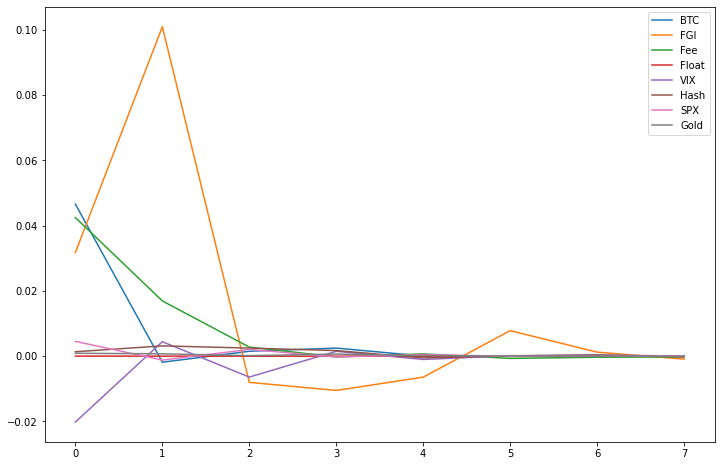

In [35]:
lag_order = model_fitted.k_ar
ax = model1_fited.impulse_responses(7,orthogonalized=True).plot(figsize=(12, 8))
plt.show()
# 横轴表示冲击作用滞后期数，纵轴表示反映变量的增长率。实线表示脉冲响应函数，
# 代表该变量受到其他变量的随机误差项的一个标准差的冲击后，该变量现在和未来的反应程度和持续时间

In [36]:
fevd = model_fitted.fevd(10)
print(fevd.summary())


FEVD for BTC
          BTC       FGI       Fee     Float       VIX      Hash       SPX      Gold
0    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1    0.995242  0.000980  0.001573  0.000003  0.000071  0.000101  0.001303  0.000727
2    0.993201  0.001100  0.001587  0.000137  0.000333  0.000387  0.001385  0.001870
3    0.992906  0.001244  0.001596  0.000143  0.000341  0.000434  0.001404  0.001932
4    0.992876  0.001255  0.001596  0.000144  0.000349  0.000434  0.001404  0.001941
5    0.992866  0.001256  0.001598  0.000144  0.000353  0.000438  0.001404  0.001941
6    0.992864  0.001257  0.001598  0.000144  0.000353  0.000439  0.001404  0.001941
7    0.992864  0.001257  0.001598  0.000144  0.000353  0.000439  0.001404  0.001941
8    0.992863  0.001257  0.001598  0.000144  0.000353  0.000439  0.001404  0.001941
9    0.992863  0.001257  0.001598  0.000144  0.000353  0.000439  0.001404  0.001941

FEVD for FGI
          BTC       FGI       Fee     Float      

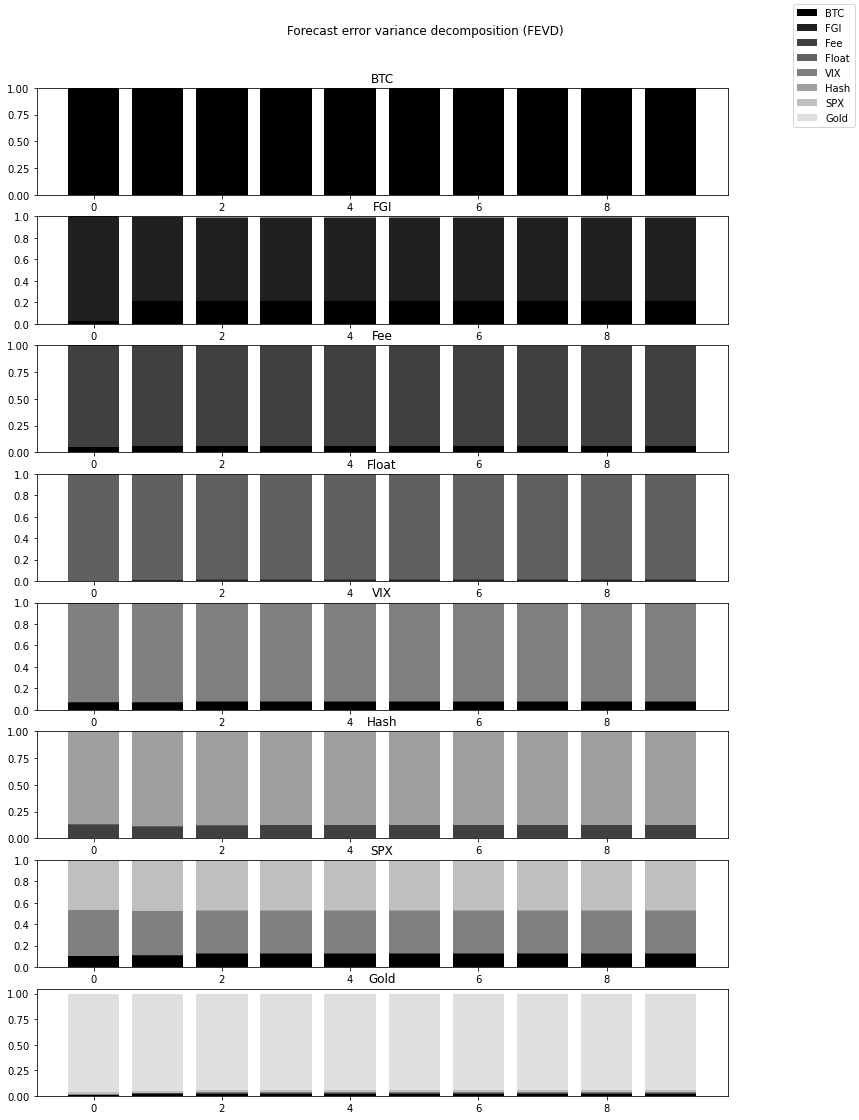

In [37]:
fevd.plot(figsize=(12, 16))
plt.show()


In [39]:
# step9：下一步进行预测
lag_order = model_fitted.k_ar
forecast_input = df_differenced.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,BTC_2d,FGI_2d,Fee_2d,Float_2d,VIX_2d,Hash_2d,SPX_2d,Gold_2d
Date,,,,,,,,
2022-11-21,-0.000343,-0.000763,0.004526,-0.000040,0.009596,0.013374,-0.002460,-0.000722
2022-11-22,0.001931,-0.010978,-0.015898,0.000024,-0.004694,-0.004567,0.001418,-0.000010
2022-11-23,0.001403,0.002873,0.001951,0.000032,-0.000765,0.002286,0.000180,0.000370
2022-11-25,0.001474,0.001054,0.004973,0.000022,0.000787,0.002659,0.000525,0.000350
2022-11-28,0.001509,-0.001760,0.002735,0.000024,0.000021,0.000891,0.000408,0.000324
2022-11-29,0.001518,-0.000813,0.001890,0.000025,-0.000054,0.002437,0.000497,0.000296
2022-11-30,0.001499,-0.000376,0.002360,0.000025,0.000098,0.001823,0.000450,0.000316


In [40]:
# step10：将差分后的值还原为原数据
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns: 
        # 写一个长度为6的数列，用纸笔写出差分的计算过程，可以帮助理解下面这两行还原过程
        df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [41]:
df_results = invert_transformation(df_train, df_forecast)  
df_results.loc[:, ['BTC_forecast', 'VIX_forecast', 'Hash_forecast', 'SPX_forecast',
                   'Gold_forecast','FGI_forecast','Fee_forecast','Float_forecast']]

,BTC_forecast,VIX_forecast,Hash_forecast,SPX_forecast,Gold_forecast,FGI_forecast,Fee_forecast,Float_forecast
Date,,,,,,,,
2022-11-21,9.723303,3.115859,19.374124,8.287634,7.461955,3.274493,1.066652,16.470874
2022-11-22,9.725505,3.086326,19.390837,8.291339,7.455913,3.402514,1.165736,16.470651
2022-11-23,9.729111,3.056028,19.409836,8.295224,7.450241,3.533407,1.266771,16.470460
2022-11-25,9.734191,3.026516,19.431494,8.299634,7.444918,3.665355,1.372779,16.470290
2022-11-28,9.740781,2.997026,19.454043,8.304453,7.439919,3.795542,1.481522,16.470145
2022-11-29,9.748889,2.967482,19.479029,8.309768,7.435216,3.924918,1.592155,16.470025
2022-11-30,9.758495,2.938036,19.505838,8.315533,7.430829,4.053917,1.705148,16.469930


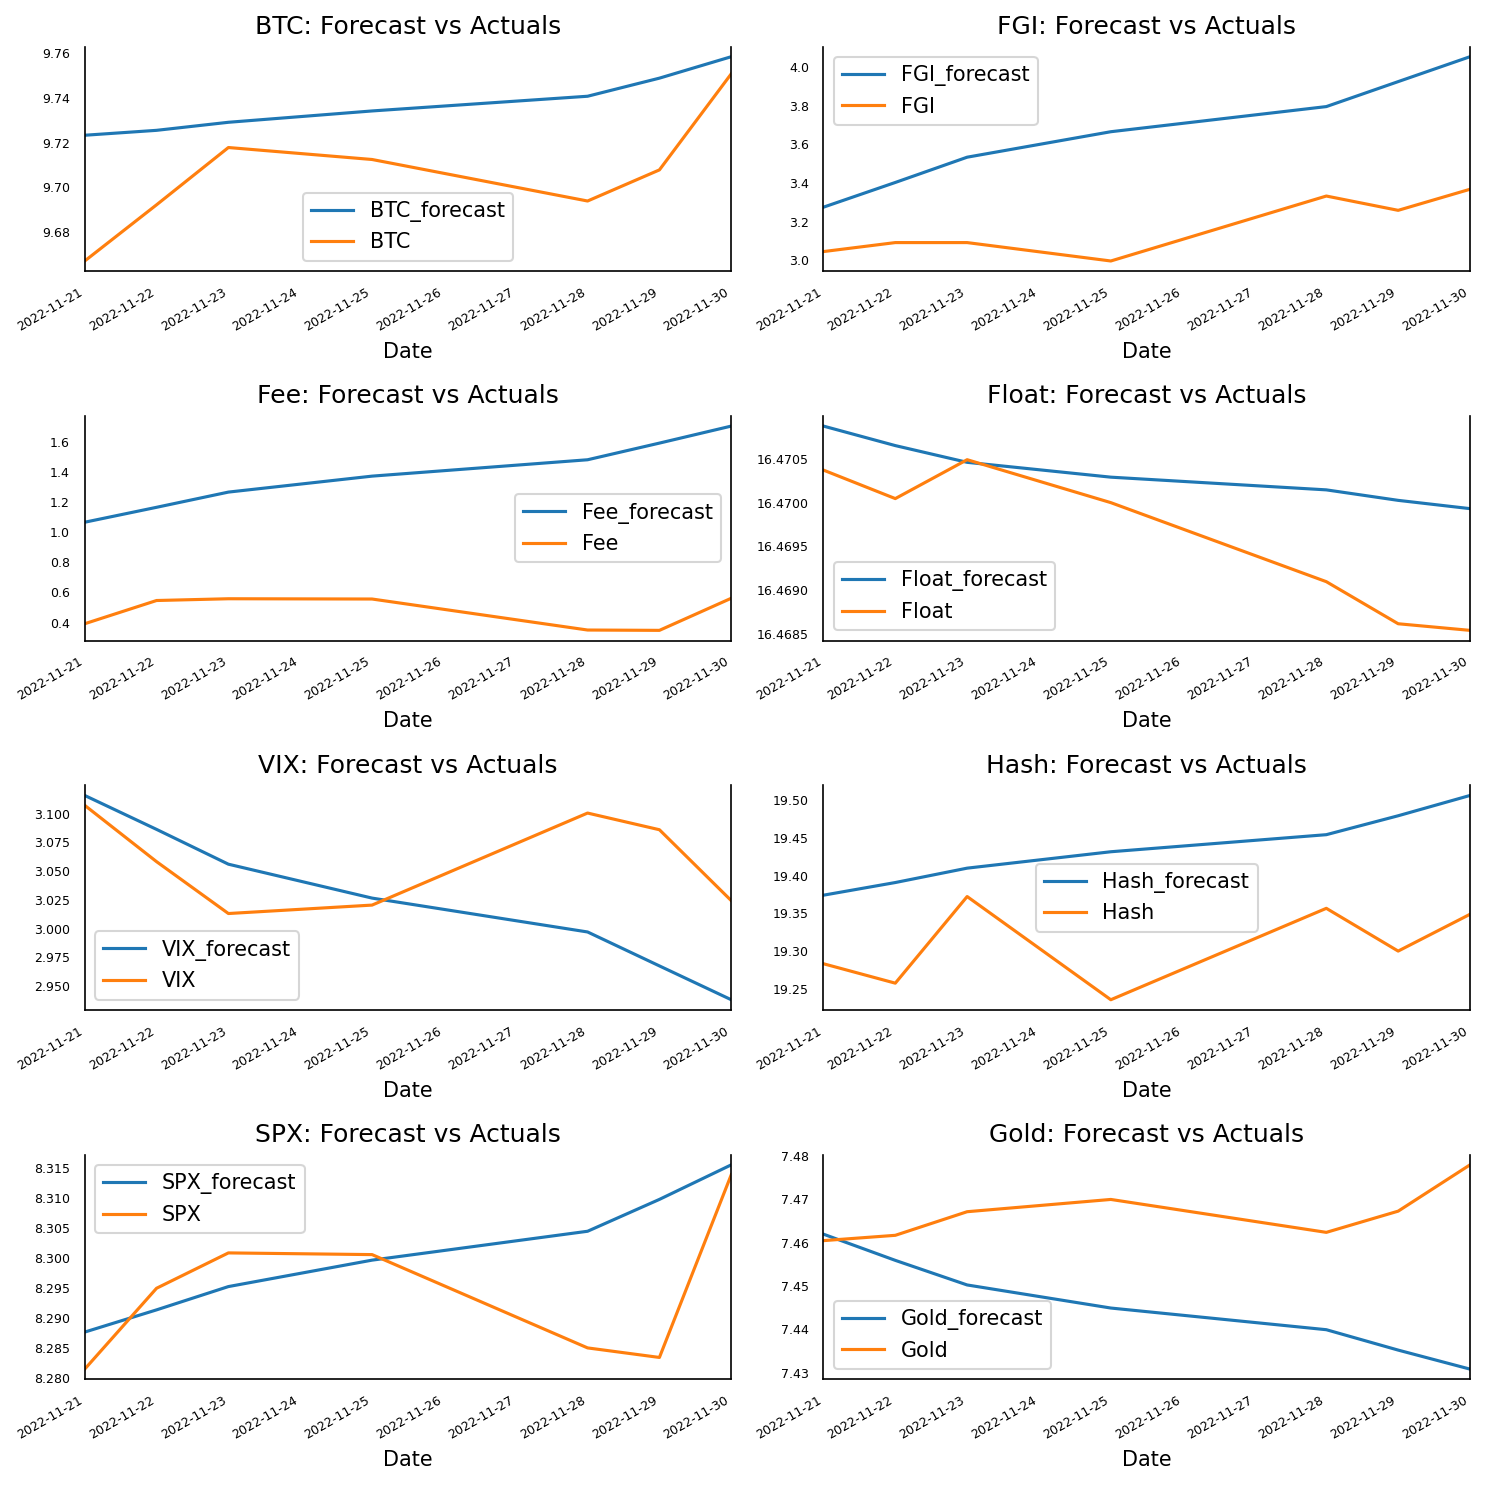

In [42]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();